<a href="https://colab.research.google.com/github/Ajblahblah-01/tweet_dataset_labelled_by_roberta/blob/main/language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
url = 'https://raw.githubusercontent.com/Ajblahblah-01/tweet_dataset_labelled_by_roberta/main/tweet_dataset.csv'
df = pd.read_csv(url)
df.head()

,Date,Tweet
0,01/02/12,Pissed for letting $QCOM slip of my radar. Don...
1,01/02/12,"The GOOG and AAPL investments were worth it, b..."
2,01/02/12,RT @timcourtney: So I missed out on $AAPL. Sho...
3,01/02/12,@ggamel You should never put all your money in...
4,01/02/12,"@ggamel You'd be playing ""bigger fool"" game in..."


In [ ]:
text = ''.join(df['Tweet'].tolist())
text[:1000]

'Pissed for letting $QCOM slip of my radar. Don\'t know what I was thinking. RT @KenShreve $QCOM too ---&gt;RT @ericjackson  $AAPLThe GOOG and AAPL investments were worth it, but FB... I\'m skeptical. And, it depends on what exchange it will trade.RT @timcourtney: So I missed out on $AAPL. Should I go for $FB? &gt; VC\'s will make $. IPO is for late to the game suckers.@ggamel You should never put all your money in 1 stock, no. But if you were to gamble like that, I\'d do AAPL. I\'d go with ETFs.@ggamel You\'d be playing "bigger fool" game investing at AMZN and FB at current valuations. I still like AAPL.now i know why the stock market is up every day.  compared to $fb everything seems cheap.  $goog $aapl $amzn$FB profited a cool billion in 2011. $AAPL profited a cool 13 billion last QUARTER. But I\'m punching my $FB retirement ticket. Bye losahs!@politicallogic Yes and our leaders seem to think it\'s OK. I also have an issue w/US co.\'s like AAPL Having 500K wrkrs in China & 50K here@

In [ ]:
import re

text = re.sub(r'[^a-zA-Z0-9\s\!\@\#\$\%\^\&\*\(\)\_\+\-\=\[\]\{\}\|\;\:\'\"\,\.\/\<\>\?]', '', text)
text[:1000]

'Pissed for letting $QCOM slip of my radar. Don\'t know what I was thinking. RT @KenShreve $QCOM too ---&gt;RT @ericjackson  $AAPLThe GOOG and AAPL investments were worth it, but FB... I\'m skeptical. And, it depends on what exchange it will trade.RT @timcourtney: So I missed out on $AAPL. Should I go for $FB? &gt; VC\'s will make $. IPO is for late to the game suckers.@ggamel You should never put all your money in 1 stock, no. But if you were to gamble like that, I\'d do AAPL. I\'d go with ETFs.@ggamel You\'d be playing "bigger fool" game investing at AMZN and FB at current valuations. I still like AAPL.now i know why the stock market is up every day.  compared to $fb everything seems cheap.  $goog $aapl $amzn$FB profited a cool billion in 2011. $AAPL profited a cool 13 billion last QUARTER. But I\'m punching my $FB retirement ticket. Bye losahs!@politicallogic Yes and our leaders seem to think it\'s OK. I also have an issue w/US co.\'s like AAPL Having 500K wrkrs in China & 50K here@

In [ ]:
chars = sorted(list(set(text)))
print(chars)

['\t', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '\xa0']


In [ ]:
chars_to_remove = ['\xa0', '|', '\t', '\n', '\r']
translation_table = str.maketrans("", "", "".join(chars_to_remove))
text = text.translate(translation_table)
print(text[:50])

Pissed for letting $QCOM slip of my radar. Don't k


In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.95*len(data)) # first 95% will be training, rest validation data
train_data = data[:n]
val_data = data[n:]

In [ ]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 5000 # number of steps
eval_interval = 100 # after how many iterations do we want the loss update
learning_rate = 1e-3 
eval_iters = 200 # while calculating loss
n_embd = 256 # embedding dimensio
n_head = 16 # number of heads in the multiattention
n_layer = 12 # number of decoder blocks
dropout = 0.1 

In [ ]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # input is embedding-dimention = 64 and output is head_size = 4
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)

        # compute attention scores

        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C) <= (block_size , batch_size , n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

9.546841 M parameters


In [ ]:
for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
## 2 million 1.60 loss
## 10 million step 4999: train loss 1.3772, val loss 1.3991

step 0: train loss 4.2456, val loss 4.2412
step 100: train loss 2.6682, val loss 2.6643
step 200: train loss 2.5883, val loss 2.5824
step 300: train loss 2.3324, val loss 2.3248
step 400: train loss 2.0701, val loss 2.0672
step 500: train loss 1.9158, val loss 1.9116
step 600: train loss 1.8297, val loss 1.8332
step 700: train loss 1.7702, val loss 1.7639
step 800: train loss 1.7172, val loss 1.7200
step 900: train loss 1.6787, val loss 1.6837
step 1000: train loss 1.6492, val loss 1.6487
step 1100: train loss 1.6213, val loss 1.6260
step 1200: train loss 1.6038, val loss 1.6106
step 1300: train loss 1.5897, val loss 1.5942
step 1400: train loss 1.5722, val loss 1.5779
step 1500: train loss 1.5523, val loss 1.5658
step 1600: train loss 1.5405, val loss 1.5514
step 1700: train loss 1.5308, val loss 1.5433
step 1800: train loss 1.5196, val loss 1.5322
step 1900: train loss 1.5163, val loss 1.5278
step 2000: train loss 1.5072, val loss 1.5211
step 2100: train loss 1.4945, val loss 1.5094


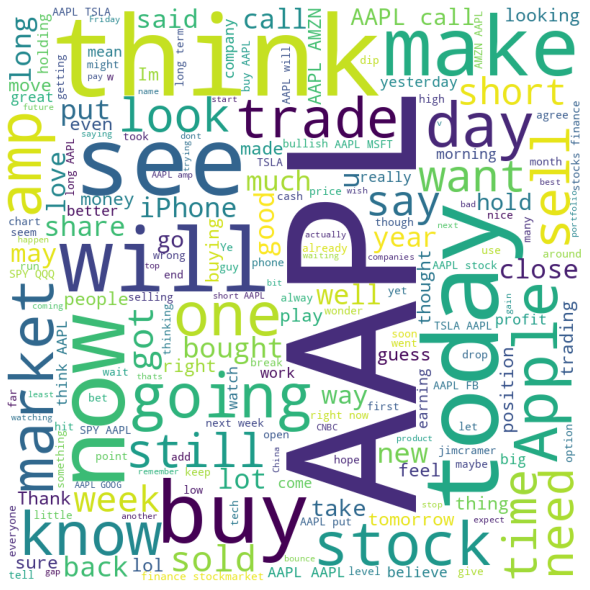

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/Ajblahblah-01/tweet_dataset_labelled_by_roberta/main/final_model_10m.pth"
model_path = "final_model_10m.pth"
urllib.request.urlretrieve(url, model_path)

('final_model_10m.pth', <http.client.HTTPMessage at 0x7f4a50146df0>)

In [ ]:
m = torch.load("/content/final_model_10m.pth" , map_location=torch.device('cpu'))
m.eval()

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))


 impact that it would be fading from me...should tough long term work on @dansplts getting nite supplier in @MKA with M&amp; frwit and maintainance chick we get into these video. Please "be missed to next chargers and but my $AAPL position and can get


In [ ]:
FILE = "final_model_10m.pth"
torch.save(model,FILE)

In [ ]:
PATH = "final_model_state_10m.pt"
torch.save(model.state_dict(), PATH)